# Proyek Klasifikasi Gambar: [Input Nama Dataset]
- **Nama:** Muhammad Thariq Arya Putra Sembiring
- **Email:** mthariqaryaputra1@gmail.com
- **ID Dicoding:** [Input Username]

## Import Semua Packages/Library yang Digunakan

In [74]:
# Kaggle
import kagglehub

# Komputasi dan data
import numpy as np
import pandas as pd
import os
import glob as gb

# Visualisasi
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# TensorFlow dan Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Konversi model
from tensorflow import lite

# Manipulasi file (optional)
import shutil
import random
from collections import defaultdict

## Data Preparation

### Download Dataset

In [20]:
# Specify the dataset name
dataset_name = "puneet6060/intel-image-classification"

# Define the destination path in /content/
destination_path = "/content/intel-image-classification"

# Download the dataset to the default Kaggle input directory
downloaded_path_default = kagglehub.dataset_download(dataset_name)
print("Dataset downloaded to default path:", downloaded_path_default)

# Copy the contents of the downloaded dataset to /content/
try:
    shutil.copytree(downloaded_path_default, destination_path)
    print(f"Copied dataset content to: {destination_path}")
except OSError as e:
    print(f"Error copying dataset: {e}")

# Construct the old and new folder paths within /content/
old_folder_path = os.path.join(destination_path, "seg_pred")
new_folder_path = os.path.join(destination_path, "seg_val")

# Check if the old folder exists before attempting to rename
if os.path.exists(old_folder_path):
    try:
        os.rename(old_folder_path, new_folder_path)
        print(f"Successfully renamed '{old_folder_path}' to '{new_folder_path}'")
    except OSError as e:
        print(f"Error renaming folder: {e}")
else:
    print(f"Warning: Folder '{old_folder_path}' not found in '{destination_path}'.")

# You can now check the contents of the destination directory
print("Contents of the dataset directory in /content/:", os.listdir(destination_path))

# Optional: Attempt to remove the original directory (might fail due to read-only FS)
# try:
#     shutil.rmtree(downloaded_path_default)
#     print(f"Successfully removed original directory: {downloaded_path_default}")
# except OSError as e:
#     print(f"Error removing original directory: {e}")

Dataset downloaded to default path: /kaggle/input/intel-image-classification
Error copying dataset: [Errno 17] File exists: '/content/intel-image-classification'
Contents of the dataset directory in /content/: ['seg_train', 'seg_val', 'seg_test']


### Data Loading

In [21]:
# Path ke folder training
train_path = "/content/intel-image-classification/seg_train/seg_train"

# Inisialisasi dictionary
class_counts = defaultdict(int)
total_images = 0

# Iterasi setiap folder kelas
for class_name in os.listdir(train_path):
    class_folder = os.path.join(train_path, class_name)
    if os.path.isdir(class_folder):
        count = len(os.listdir(class_folder))
        class_counts[class_name] = count
        total_images += count

# Tampilkan hasil
print("Jumlah gambar per kelas:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} gambar")

print("\nTotal gambar di train set:", total_images)

Jumlah gambar per kelas:
glacier: 2404 gambar
street: 2382 gambar
sea: 2274 gambar
mountain: 2512 gambar
buildings: 2191 gambar
forest: 2271 gambar

Total gambar di train set: 14034


In [22]:
# Path ke folder testing
test_path = "/content/intel-image-classification/seg_test/seg_test"

# Inisialisasi dictionary
class_counts = defaultdict(int)
total_images = 0

# Iterasi setiap folder kelas
for class_name in os.listdir(test_path):
    class_folder = os.path.join(test_path, class_name)
    if os.path.isdir(class_folder):
        count = len(os.listdir(class_folder))
        class_counts[class_name] = count
        total_images += count

# Tampilkan hasil
print("Jumlah gambar per kelas:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} gambar")

print("\nTotal gambar di test set:", total_images)

Jumlah gambar per kelas:
glacier: 553 gambar
street: 501 gambar
sea: 510 gambar
mountain: 525 gambar
buildings: 437 gambar
forest: 474 gambar

Total gambar di test set: 3000


In [23]:
# Path ke folder validation
val_path = "/content/intel-image-classification/seg_val/seg_val"

# Hitung jumlah file langsung di folder seg_val
val_files = [f for f in os.listdir(val_path) if os.path.isfile(os.path.join(val_path, f))]
total_val_images = len(val_files)

print("Jumlah gambar di validation set:", total_val_images)

Jumlah gambar di validation set: 7301


### Data Preprocessing

#### Check Image Size

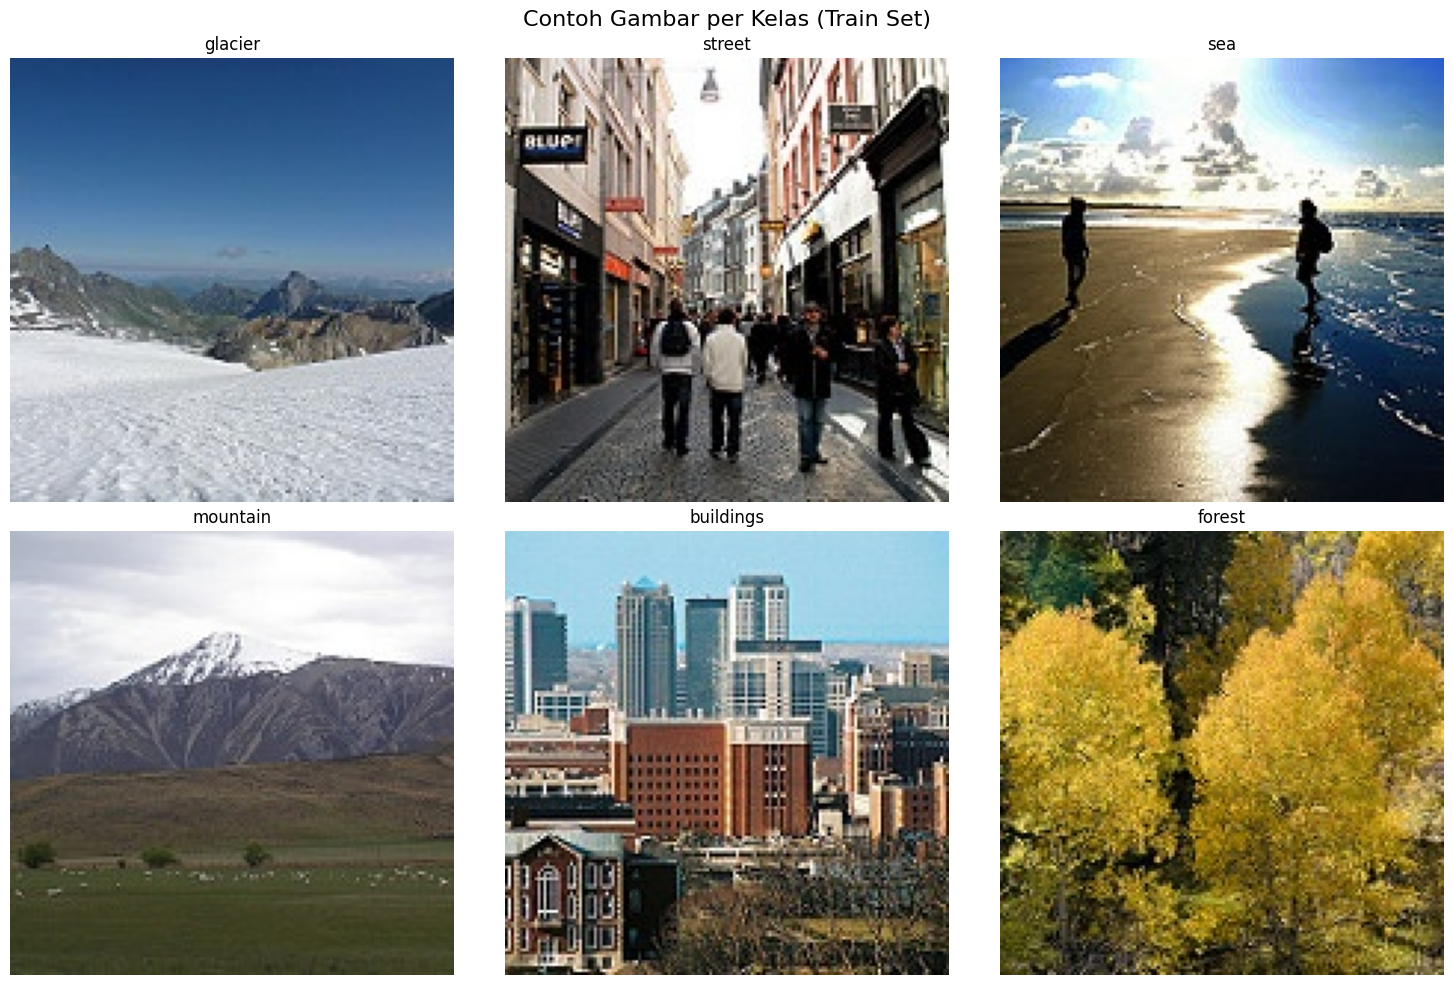

In [24]:
# Ambil daftar kelas
class_names = os.listdir(train_path)

# Plot contoh gambar dari setiap kelas
plt.figure(figsize=(15, 10))

for i, class_name in enumerate(class_names):
    class_folder = os.path.join(train_path, class_name)
    image_files = os.listdir(class_folder)

    if image_files:  # pastikan folder tidak kosong
        image_path = os.path.join(class_folder, image_files[0])
        img = mpimg.imread(image_path)

        plt.subplot(2, 3, i + 1)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis('off')

plt.suptitle("Contoh Gambar per Kelas (Train Set)", fontsize=16)
plt.tight_layout()
plt.show()

In [25]:
# Train Set
size = []

# Iterasi semua folder kelas
for folder in os.listdir(train_path):
    files = gb.glob(os.path.join(train_path, folder, "*.jpg"))
    for file in files:
        image = plt.imread(file)
        size.append(image.shape)

# Hitung jumlah gambar untuk setiap ukuran
pd.Series(size).value_counts()

,count
"(150, 150, 3)",13986
"(113, 150, 3)",7
"(111, 150, 3)",3
"(135, 150, 3)",3
"(123, 150, 3)",2
"(143, 150, 3)",2
"(142, 150, 3)",2
"(136, 150, 3)",2
"(144, 150, 3)",2
"(134, 150, 3)",2


In [26]:
# Test Set
size = []

# Iterasi semua folder kelas
for folder in os.listdir(test_path):
    files = gb.glob(os.path.join(test_path, folder, "*.jpg"))
    for file in files:
        image = plt.imread(file)
        size.append(image.shape)

# Hitung jumlah gambar untuk setiap ukuran
pd.Series(size).value_counts()

,count
"(150, 150, 3)",2993
"(76, 150, 3)",1
"(72, 150, 3)",1
"(149, 150, 3)",1
"(110, 150, 3)",1
"(81, 150, 3)",1
"(131, 150, 3)",1
"(141, 150, 3)",1


#### Resize Image to 100x100

In [37]:
# Target size gambar
IMG_SIZE = (100, 100)
BATCH_SIZE = 32

# Data Augmentation untuk train set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

# Data generator untuk training (dengan augmentasi)
train_generator = train_datagen.flow_from_directory(
    "/content/intel-image-classification/seg_train/seg_train",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',  # Menggunakan label dari folder
    shuffle=True
)

# Data generator untuk validation (tanpa augmentasi, karena tidak ada label)
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    "/content/intel-image-classification/seg_val/seg_val",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode=None,  # Tidak ada label, hanya gambar
    shuffle=False  # Tidak di-shuffle untuk validasi
)

# Data generator untuk test set (tanpa augmentasi)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    "/content/intel-image-classification/seg_test/seg_test",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',  # Menggunakan label dari folder
    shuffle=False  # Tidak perlu shuffle untuk test set
)

Found 14034 images belonging to 6 classes.
Found 0 images belonging to 0 classes.
Found 3000 images belonging to 6 classes.


#### Split Dataset and Encode Label

In [38]:
# Fungsi untuk mengubah generator jadi array
def generator_to_numpy(generator):
    x = []
    y = []
    for i in range(len(generator)):
        batch = generator[i]
        x.append(batch[0])
        y.append(batch[1])
    return np.concatenate(x), np.concatenate(y)

In [39]:
# Tampilkan mapping label
print("Label mapping dari train_generator:", train_generator.class_indices)

Label mapping dari train_generator: {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


In [40]:
# Konversi train dan test set ke numpy array
x_train, y_train = generator_to_numpy(train_generator)
x_test, y_test = generator_to_numpy(test_generator)

In [41]:
# Ubah dari one-hot ke label integer
y_train_labels = np.argmax(y_train, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (14034, 100, 100, 3)
y_train shape: (14034, 6)
x_test shape: (3000, 100, 100, 3)
y_test shape: (3000, 6)


#### Normalization

In [42]:
# Normalisasi data (nilai pixel jadi antara 0-1)
x_train = x_train / 255.0
x_test = x_test / 255.0

## Modelling

In [52]:
model = Sequential([
    Input(shape=(100, 100, 3)),

    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(6, activation='softmax')
])

In [53]:
# Early stopping untuk menghentikan pelatihan jika tidak ada peningkatan
early_stopping = EarlyStopping(
    monitor='val_loss',  # Bisa juga gunakan 'val_accuracy'
    patience=3,           # Berhenti setelah 3 epoch tanpa peningkatan
    restore_best_weights=True
)

# ModelCheckpoint untuk menyimpan model terbaik berdasarkan val_loss
checkpoint = ModelCheckpoint(
    'best_model.h5',  # Nama file untuk model terbaik
    monitor='val_loss',  # Bisa juga gunakan 'val_accuracy'
    save_best_only=True,
    mode='min',  # Karena kita ingin val_loss sekecil mungkin
    verbose=1
)

In [54]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [57]:
history = model.fit(
    x_train, y_train_labels,
    epochs=15,
    validation_data=(x_test, y_test_labels),
    batch_size=32,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/15
438/439 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7997 - loss: 0.5592
Epoch 1: val_loss did not improve from 0.82604
439/439 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.7997 - loss: 0.5593 - val_accuracy: 0.3920 - val_loss: 4.5455
Epoch 2/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8130 - loss: 0.5604
Epoch 2: val_loss did not improve from 0.82604
439/439 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.8130 - loss: 0.5604 - val_accuracy: 0.4730 - val_loss: 1.3741
Epoch 3/15
438/439 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8422 - loss: 0.4594
Epoch 3: val_loss did not improve from 0.82604
439/439 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.8421 - loss: 0.4595 - val_accuracy: 0.4127 - val_loss: 2.1109
Epoch 4/15
436/439 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8518 - loss: 0.4332
Epoch 4: val_loss did not improve from 0.82604
439/439 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.8517 - loss: 0.4333 - val_accuracy: 0.5453 - val_los

## Evaluasi dan Visualisasi

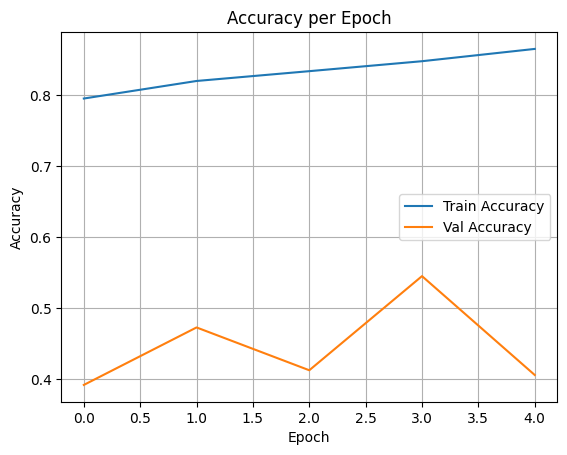

In [59]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

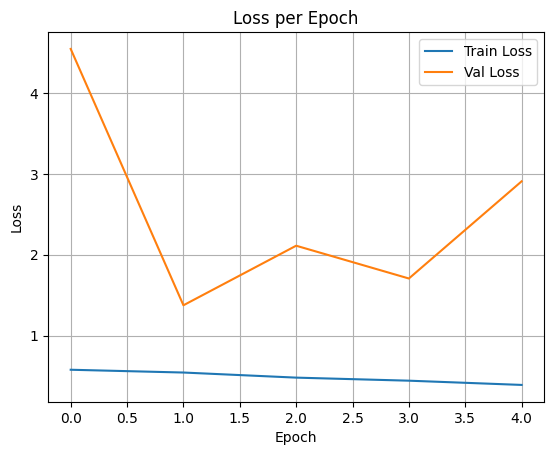

In [61]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

## Konversi Model

In [65]:
# Simpan dalam format SavedModel
model.export("model_saved")

Saved artifact at 'model_saved'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name='keras_tensor_22')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  132912864419600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132912864417296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132912716634768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132912716635920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132912864418640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132912716632464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132912716631504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132912716634192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132912716635728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132912716637456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132912716633232:

In [68]:
converter = tf.lite.TFLiteConverter.from_saved_model("model_saved")
tflite_model = converter.convert()

# Simpan model TFLite
with open("tflite/model.tflite", "wb") as f:
    f.write(tflite_model)

# Buat file label.txt
labels = list(train_generator.class_indices.keys())
with open("tflite/label.txt", "w") as f:
    for label in labels:
        f.write(label + "\n")

In [71]:
# TFJS
!pip install tensorflowjs

In [73]:
!tensorflowjs_converter \
    --input_format=tf_saved_model \
    model_saved \
    tfjs_model

2025-05-13 02:19:55.771381: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747102795.792202   12553 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747102795.798100   12553 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-05-13 02:20:00.982460: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1747102800.982634   12553 gpu_device.cc:2022] Created device /job:localhost/replica:0/task

## Inference (Optional)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step


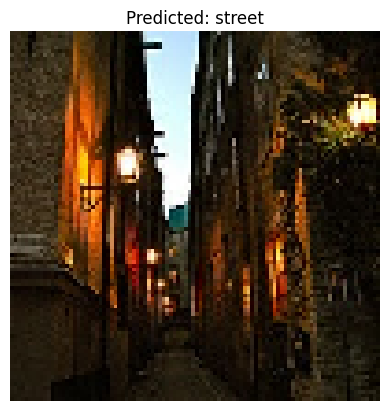

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


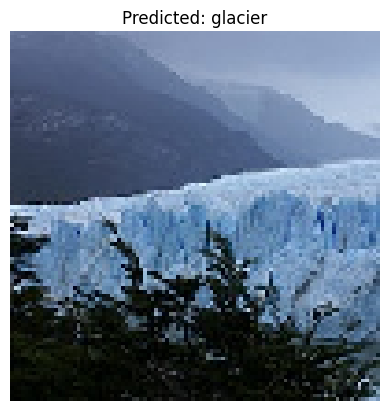

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


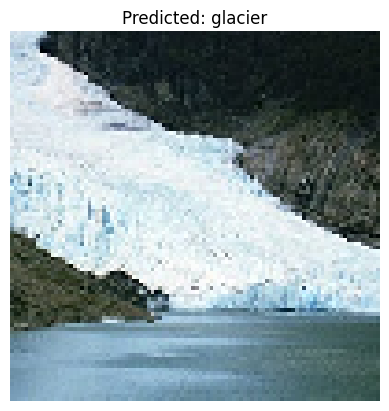

In [111]:
# Step 1: Load model from .h5 file
model = load_model("best_model.h5")

# Step 2: Path to seg_val
val_path = "/content/intel-image-classification/seg_val/seg_val"
val_images = [os.path.join(val_path, fname) for fname in os.listdir(val_path) if fname.endswith(".jpg")]

# Step 3: Randomly select 10 images
random_images = random.sample(val_images, 3)

# Label decoder (index to label)
code = {'buildings': 0 ,'forest':1 ,'glacier':2,'mountain':3 ,'sea':4 ,'street':5}
def getcode(n):
    for x, y in code.items():
        if n == y:
            return x

# Step 4: Inference
for img_path in random_images:
    img = image.load_img(img_path, target_size=(100, 100))
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction[0])
    predicted_label = getcode(predicted_class)

    # Display
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_label}")
    plt.axis("off")
    plt.show()